In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.layers import Dropout, Dense, GlobalAveragePooling2D, Conv2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.activations import swish
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
df = pd.read_csv("DataSet/HAM.csv")
df['image_id'] = df['image_id'].apply(lambda x: x + ".jpg")
class_counts = df['dx'].value_counts()

# Print the counts for each class
print(class_counts)

dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64


In [3]:
# Define image dimensions and batch size
img_size = (100, 100)
batch_size = 16

# Create data generators for augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2
)

In [4]:
train_df, test_valid_df = train_test_split(df, test_size=0.3, random_state=42)
test_df, valid_df = train_test_split(test_valid_df, test_size=0.5, random_state=42)
train_df['image_id'] = 'DataSet/Combined/' + train_df['image_id']
valid_df['image_id'] = 'DataSet/Combined/' + valid_df['image_id']
test_df['image_id'] = 'DataSet/Combined/' + test_df['image_id']

In [5]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2
)

valid_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='image_id',
    y_col='dx',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

valid_generator = valid_datagen.flow_from_dataframe(
    valid_df,
    x_col='image_id',
    y_col='dx',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    test_df,
    x_col='image_id',
    y_col='dx',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

Found 7010 validated image filenames belonging to 7 classes.
Found 1503 validated image filenames belonging to 7 classes.
Found 1502 validated image filenames belonging to 7 classes.


In [6]:
base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3))



x = base_model.output
x = Conv2D(64, (3, 3), activation='relu')(x)
x = BatchNormalization()(x)
x = GlobalAveragePooling2D()(x)

x = Dropout(0.5)(x)
x = Dense(1024, activation=swish)(x)
x = Dropout(0.5)(x)
x = Dense(256, activation=swish)(x)
x = Dropout(0.5)(x)

predictions = Dense(7, activation='softmax')(x)  # Replace NUM_CLASSES with the number of classes

model = Model(inputs=base_model.input, outputs=predictions)

In [7]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [8]:
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=150,  # You can adjust the number of epochs
    steps_per_epoch=len(train_generator),
    validation_steps=len(valid_generator)
)

Epoch 1/150
439/439 [==============================] - 194s 367ms/step - loss: 1.0923 - accuracy: 0.6496 - val_loss: 3.8584 - val_accuracy: 0.6254
Epoch 2/150
439/439 [==============================] - 76s 172ms/step - loss: 0.9535 - accuracy: 0.6713 - val_loss: 4.7696 - val_accuracy: 0.3400
Epoch 3/150
439/439 [==============================] - 75s 171ms/step - loss: 0.8933 - accuracy: 0.6817 - val_loss: 0.8864 - val_accuracy: 0.6773
Epoch 4/150
439/439 [==============================] - 75s 171ms/step - loss: 0.8588 - accuracy: 0.6884 - val_loss: 1.3457 - val_accuracy: 0.3240
Epoch 5/150
439/439 [==============================] - 75s 171ms/step - loss: 0.8805 - accuracy: 0.6863 - val_loss: 1.3511 - val_accuracy: 0.5988
Epoch 6/150
439/439 [==============================] - 78s 177ms/step - loss: 0.8481 - accuracy: 0.6940 - val_loss: 0.8233 - val_accuracy: 0.6820
Epoch 7/150
439/439 [==============================] - 76s 173ms/step - loss: 0.8320 - accuracy: 0.6926 - val_loss: 1.3556 

In [9]:
test_loss, test_accuracy = model.evaluate(test_generator, steps=len(test_generator))
print(f'Test accuracy: {test_accuracy * 100:.2f}%')

94/94 [==============================] - 25s 271ms/step - loss: 2901.2854 - accuracy: 0.7217
Test accuracy: 72.17%


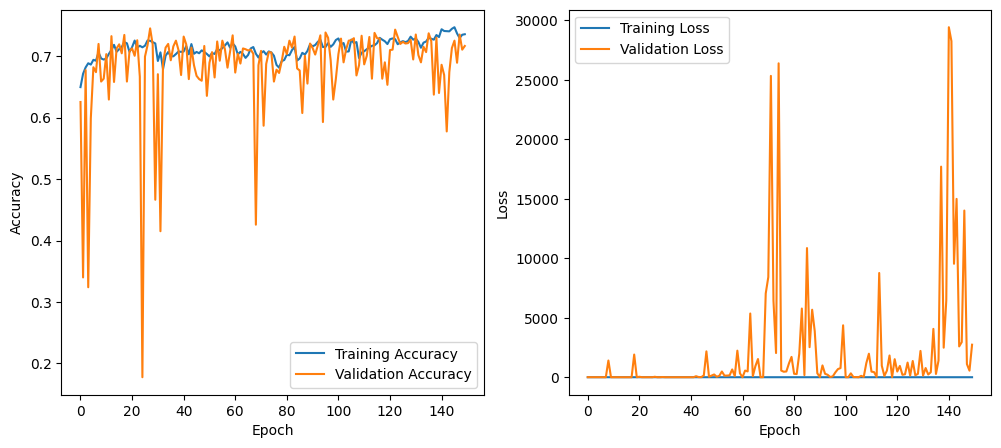

In [10]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [11]:
model.save('New_DenseNet_model.h5')